In [1]:
%matplotlib inline
import IPython
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import pyaudio

#### Utilities

In [2]:
def signal(pattern, pulse):
    pulse = np.array(pulse);
    return np.array([ampl * pulse for ampl in pattern]).flatten()

In [3]:
def match_decoder(signal, pulse, dt_sampling, decision):
    match = np.convolve(signal, pulse[::-1])
    samples = match[np.arange(0, len(match), dt_sampling)]
    return [decision(s) for s in samples]

In [4]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [5]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

#### Shared parameters

In [6]:
rate = 8192
max_t = rate * 15 # 15s
t = 1/rate

dt_sampling = 100
pulse = np.ones(dt_sampling)

delim_pad = 4
delim_pat = 15
delim = np.zeros(delim_pat + 2 * delim_pad) # alternating -1/1 starting/ending with 1's
delim[0::2] = 1
delim[1::2] = -1
delim[0:delim_pad] = 1
delim[delim_pat + delim_pad:] = 1

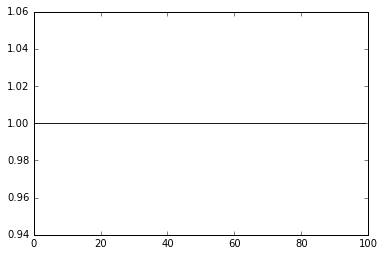

In [7]:
plt.plot(pulse)
plt.show()

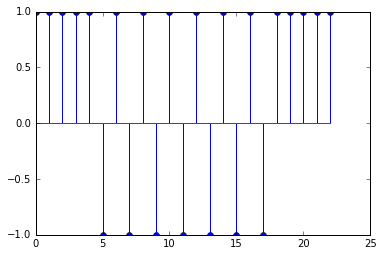

In [8]:
plt.stem(delim)
plt.show()

#### Emitter

In [9]:
d = "The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)"
len(d)

137

In [10]:
d_bin = binarize(d)
assert d == textarize(d_bin)
d_code = [1 if x == 0 else -1 for x in d_bin]
len(d_code)

1096

In [11]:
dt_origin = 756

s_delay = np.zeros(dt_origin)
s_delim = signal(delim, pulse)
s_data = signal(d_code, pulse)

s = np.concatenate((s_delay, s_delim, s_data))

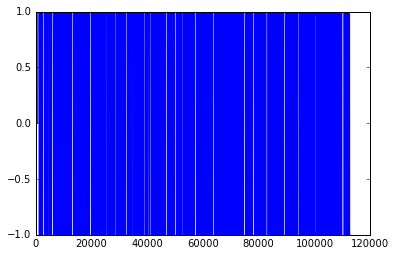

In [12]:
plt.plot(s)
plt.show()

In [13]:
IPython.display.Audio(s, rate=rate)

#### Channel

In [14]:
c_rate, c = wavfile.read("interference.wav")
assert rate == c_rate
IPython.display.Audio(c, rate=rate)

In [15]:
c_mean = np.mean(c)
c_std = np.std(c)
s_ampl = c_std * 2

In [16]:
sn = s * s_ampl + c[:len(s)]
IPython.display.Audio(sn, rate=rate)

#### Receiver

In [17]:
xcorr = np.correlate(sn, s_delim)
dt_delay = np.argmax(xcorr)

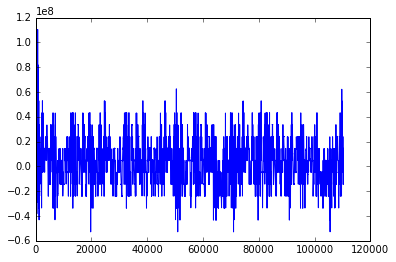

In [18]:
plt.plot(xcorr)
plt.show()

In [19]:
r_shift = sn[dt_delay:]
r_align = match_decoder(r_shift, pulse, dt_sampling, lambda x: -1 if x < 0 else 1)
r_code = r_align[len(delim):]

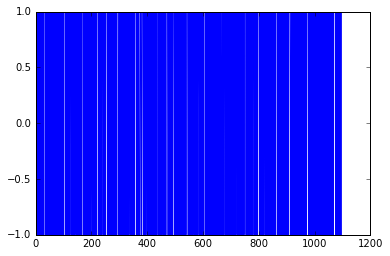

In [20]:
plt.plot(r_code)
plt.show()

In [21]:
r = [0 if x == 1 else 1 for x in r_code]

r_str = textarize(r[1:])
print(d)
print(r_str)

The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)
The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)


#### Record

In [22]:
ex_chunk = 1024
ex_format = pyaudio.paFloat32
ex_channel = 2
ex_sec = 5

p = pyaudio.PyAudio()
stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
buf = []

for i in range(0, int(rate / ex_chunk * ex_sec)):
    data = stream.read(ex_chunk)
    buf.append(np.fromstring(data, 'Float32'))

stream.stop_stream()
stream.close()
p.terminate()

ex_chan = np.array(buf).flatten()

In [23]:
ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
ex = [np.average(g) for g in ex_group]
assert len(ex) == len(ex_chan) / ex_channel
IPython.display.Audio(ex, rate=rate)

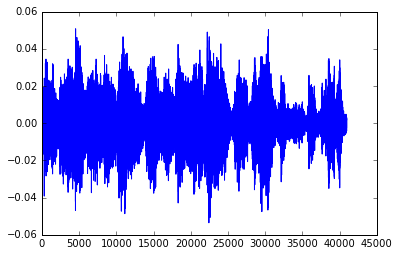

In [24]:
plt.plot(ex)
plt.show()

In [25]:
#sn = ex

#### Todos

- amplitude bounds (100Hz - 20KHz)
- mean noise subtraction
- find best amplitude
- lowerpass match
- block with parity checks
